# Regression models

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_parquet('../10-data/data_final.parquet')
print(data.shape)
data.head()

(4768, 23)


,Title,Year,Country,BoxOffice,runtimeMinutes,genres,averageRating,numVotes,isRated,ForeignLanguage,...,won_Oscar,plot_sentiment_polarity,plot_sentiment_score,isPositivePlot,isFiction,Competitiveness,Cooperativeness,logBoxOffice,logRunTime,logNumVotes
0,Shadow Play,1996,"[France, United Kingdom]",3.053799e+04,111.0,"Comedy,Romance",5.8,495,False,False,...,False,positive,0.996212,1.0,True,8.563351,9.607148,10.326727,4.709530,6.204558
1,Down by Love,2016,"[France, Belgium]",8.230545e+02,110.0,"Biography,Drama,Romance",5.9,2296,True,False,...,False,positive,0.998860,1.0,True,11.997840,10.791093,6.713022,4.700480,7.738924
2,Heavenly Bodies,1984,[Canada],5.182512e+06,89.0,"Drama,Romance",5.2,882,True,True,...,False,negative,0.993147,0.0,True,7.111757,8.025091,15.460800,4.488636,6.782192
3,High Season,1987,[United Kingdom],2.897574e+06,90.0,"Comedy,Romance",5.3,459,True,False,...,False,positive,0.989917,1.0,True,7.748589,8.581463,14.879384,4.499810,6.129050
4,Bright Days Ahead,2013,[France],2.734882e+04,94.0,"Drama,Romance",6.3,1843,False,False,...,False,positive,0.995390,1.0,True,11.164641,12.082496,10.216429,4.543295,7.519150


# OLS models

## Baseline model (just linear trend)

<Axes: xlabel='Year'>

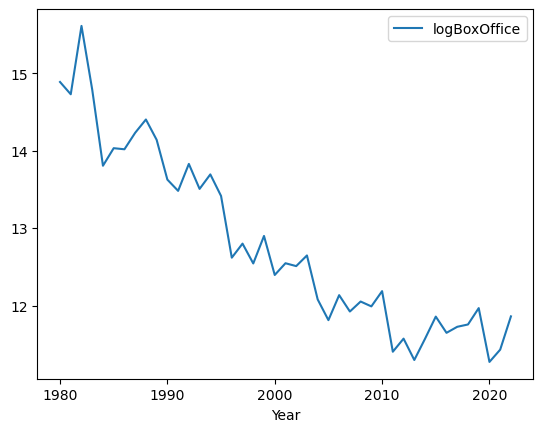

In [3]:
#Why is it reasonable?
data[['Year','logBoxOffice']].groupby('Year').mean().plot()

In [4]:
X = data[['Year']]
X = sm.add_constant(X)
y = data['logBoxOffice']

ols_baseline = sm.OLS(y, X).fit()
print(ols_baseline.summary())

                            OLS Regression Results                            
Dep. Variable:           logBoxOffice   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     560.7
Date:                Wed, 17 Jan 2024   Prob (F-statistic):          2.81e-117
Time:                        19:00:05   Log-Likelihood:                -10602.
No. Observations:                4768   AIC:                         2.121e+04
Df Residuals:                    4766   BIC:                         2.122e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        162.1442      6.332     25.609      0.0

In [5]:
data.columns

Index(['Title', 'Year', 'Country', 'BoxOffice', 'runtimeMinutes', 'genres',
       'averageRating', 'numVotes', 'isRated', 'ForeignLanguage',
       'isCoproduction', 'win_award', 'nominated_award', 'won_Oscar',
       'plot_sentiment_polarity', 'plot_sentiment_score', 'isPositivePlot',
       'isFiction', 'Competitiveness', 'Cooperativeness', 'logBoxOffice',
       'logRunTime', 'logNumVotes'],
      dtype='object')

## Covariates model

In [6]:
X = data[['Year',
          'logRunTime',
          'averageRating',
          'isRated',
          'ForeignLanguage',
          'isCoproduction',
          'win_award',
          'nominated_award',
          'won_Oscar',
          'plot_sentiment_score',
          'isPositivePlot',
          'isFiction']].astype('float')
X = sm.add_constant(X)
y = data['logBoxOffice']

ols_covs = sm.OLS(y, X).fit()
print(ols_covs.summary())

                            OLS Regression Results                            
Dep. Variable:           logBoxOffice   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     165.3
Date:                Wed, 17 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:00:05   Log-Likelihood:                -10036.
No. Observations:                4768   AIC:                         2.010e+04
Df Residuals:                    4755   BIC:                         2.018e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  103.2861 

## Covariates + Cooperativeness

In [7]:
X = data[['Year',
          'logRunTime',
          'averageRating',
          'isRated',
          'ForeignLanguage',
          'isCoproduction',
          'win_award',
          'nominated_award',
          'won_Oscar',
          'plot_sentiment_score',
          'isPositivePlot',
          'isFiction',
          'Cooperativeness',]].astype('float')
X = sm.add_constant(X)
y = data['logBoxOffice']

ols_coop = sm.OLS(y, X).fit()
print(ols_coop.summary())

                            OLS Regression Results                            
Dep. Variable:           logBoxOffice   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     154.4
Date:                Wed, 17 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:00:05   Log-Likelihood:                -10027.
No. Observations:                4768   AIC:                         2.008e+04
Df Residuals:                    4754   BIC:                         2.017e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  126.5858 

## Covariates + Competitiveness

In [8]:
X = data[['Year',
          'logRunTime',
          'averageRating',
          'isRated',
          'ForeignLanguage',
          'isCoproduction',
          'win_award',
          'nominated_award',
          'won_Oscar',
          'plot_sentiment_score',
          'isPositivePlot',
          'isFiction',
          'Competitiveness',]].astype('float')
X = sm.add_constant(X)
y = data['logBoxOffice']

ols_comp = sm.OLS(y, X).fit()
print(ols_comp.summary())

                            OLS Regression Results                            
Dep. Variable:           logBoxOffice   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     153.1
Date:                Wed, 17 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:00:05   Log-Likelihood:                -10033.
No. Observations:                4768   AIC:                         2.009e+04
Df Residuals:                    4754   BIC:                         2.018e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  121.0252 

## Full OLS model

In [9]:
X = data[['Year',
          'logRunTime',
          'averageRating',
          'isRated',
          'ForeignLanguage',
          'isCoproduction',
          'nominated_award',
          'win_award',
          'won_Oscar',
          'plot_sentiment_score',
          'isPositivePlot',
          'isFiction',
          'Cooperativeness',
          'Competitiveness',]].astype('float')
X = sm.add_constant(X)
y = data['logBoxOffice']

ols_full = sm.OLS(y, X).fit()
print(ols_full.summary())

                            OLS Regression Results                            
Dep. Variable:           logBoxOffice   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     143.4
Date:                Wed, 17 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:00:05   Log-Likelihood:                -10027.
No. Observations:                4768   AIC:                         2.008e+04
Df Residuals:                    4753   BIC:                         2.018e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  123.4694 

## OLS models comparison

In [10]:
from stargazer.stargazer import Stargazer, LineLocation

stargazer = Stargazer([ ols_baseline,
                       ols_covs, 
                       ols_comp,
                       ols_coop,
                       ols_full,])
stargazer.covariate_order(X.columns)
stargazer.custom_columns(['Trend only', 
                          'Covariates only', 
                          'Competitiveness & covs',
                          'Cooperation & covs',
                          'Full model',
                         ], [1,1,1,1,1])
stargazer.show_model_numbers(True)
stargazer

## Covariates + Cooperativeness, Multilevel

In [11]:
X = data[['Year',
          'logRunTime',
          'averageRating',
          'isRated',
          'ForeignLanguage',
          'isCoproduction',
          'nominated_award',
          'win_award',
          'won_Oscar',
          'plot_sentiment_score',
          'isPositivePlot',
          'isFiction',
          'Cooperativeness',]].astype('float')
X = sm.add_constant(X)
y = data['logBoxOffice']

# Defining the groups for varying intercepts (country and year combination)
groups = data['Country'].astype(str) + ':' + data['Year'].astype(str)

# Creating the mixed-effects model with varying intercepts for country-year combinations
hlm_coop = sm.MixedLM(y, X, groups=groups).fit()

# Printing the summary of the model
print(hlm_coop.summary())

               Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    logBoxOffice
No. Observations:    4768       Method:                REML        
No. Groups:          2370       Scale:                 3.1476      
Min. group size:     1          Log-Likelihood:        -9917.4666  
Max. group size:     29         Converged:             Yes         
Mean group size:     2.0                                           
-------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------
const                147.452    9.430  15.636 0.000 128.968 165.935
Year                  -0.075    0.005 -15.778 0.000  -0.084  -0.066
logRunTime             2.040    0.166  12.311 0.000   1.715   2.365
averageRating          0.325    0.035   9.342 0.000   0.257   0.393
isRated                1.438    0.062  23.043 0.000   1.316   1

## Covariates + Competitiveness, Multilevel

In [12]:
X = data[['Year',
          'logRunTime',
          'averageRating',
          'isRated',
          'ForeignLanguage',
          'isCoproduction',
          'nominated_award',
          'win_award',
          'won_Oscar',
          'plot_sentiment_score',
          'isPositivePlot',
          'isFiction',
          'Competitiveness',]].astype('float')
X = sm.add_constant(X)
y = data['logBoxOffice']

# Defining the groups for varying intercepts (country and year combination)
groups = data['Country'].astype(str) + ':' + data['Year'].astype(str)

# Creating the mixed-effects model with varying intercepts for country-year combinations
hlm_comp = sm.MixedLM(y, X, groups=groups).fit()

# Printing the summary of the model
print(hlm_comp.summary())

               Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    logBoxOffice
No. Observations:    4768       Method:                REML        
No. Groups:          2370       Scale:                 3.1557      
Min. group size:     1          Log-Likelihood:        -9924.8672  
Max. group size:     29         Converged:             Yes         
Mean group size:     2.0                                           
-------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------
const                148.511   11.387  13.042 0.000 126.192 170.830
Year                  -0.075    0.006 -13.065 0.000  -0.087  -0.064
logRunTime             2.051    0.166  12.354 0.000   1.726   2.376
averageRating          0.331    0.035   9.483 0.000   0.262   0.399
isRated                1.444    0.063  23.089 0.000   1.321   1

In [13]:
data.Competitiveness.sample(5)

903      8.045236
667      9.685872
1031    11.485434
4053    11.234068
4074     7.745782
Name: Competitiveness, dtype: float64

## Full Multilevel model

In [14]:
X = data[['Year',
          'logRunTime',
          'averageRating',
          'isRated',
          'ForeignLanguage',
          'isCoproduction',
          'nominated_award',
          'win_award',
          'won_Oscar',
          'plot_sentiment_score',
          'isPositivePlot',
          'isFiction',
          'Cooperativeness',
          'Competitiveness',]].astype('float')
X = sm.add_constant(X)
y = data['logBoxOffice']

In [15]:
# Defining the groups for varying intercepts (country and year combination)
groups = data['Country'].astype(str) + ':' + data['Year'].astype(str)

# Creating the mixed-effects model with varying intercepts for country-year combinations
hlm_full = sm.MixedLM(y, X, groups=groups).fit()

# Printing the summary of the model
print(hlm_full.summary())

               Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    logBoxOffice
No. Observations:    4768       Method:                REML        
No. Groups:          2370       Scale:                 3.1468      
Min. group size:     1          Log-Likelihood:        -9919.5948  
Max. group size:     29         Converged:             Yes         
Mean group size:     2.0                                           
-------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------
const                151.112   11.387  13.271 0.000 128.794 173.430
Year                  -0.077    0.006 -13.312 0.000  -0.088  -0.066
logRunTime             2.042    0.166  12.317 0.000   1.717   2.367
averageRating          0.326    0.035   9.355 0.000   0.258   0.394
isRated                1.437    0.062  23.004 0.000   1.314   1

## Model comparison

In [16]:
from stargazer.stargazer import Stargazer, LineLocation

stargazer = Stargazer([ ols_baseline,
                       ols_covs, 
                       ols_comp,
                       ols_coop,
                       ols_full,
                       hlm_comp,
                       hlm_coop,
                       hlm_full,])
stargazer.covariate_order(X.columns)
stargazer.custom_columns(['Trend only', 
                          'Covariates only', 
                          'Competitiveness & covs',
                          'Cooperation & covs',
                          'Full model',
                          'Competitiveness & covs',
                          'Cooperation & covs',
                          'Full model'], [1,1,1,1,1,1,1,1])
stargazer.add_line('Model type', ['OLS', 'OLS','OLS','OLS','OLS','HLM','HLM','HLM'], LineLocation.HEADER_BOTTOM)
stargazer.show_model_numbers(True)
stargazer

## Diagnostics

In [17]:
model=ols_full

# Extract residuals and fitted values
Zres = model.resid/model.resid.std()
yhat = model.fittedvalues

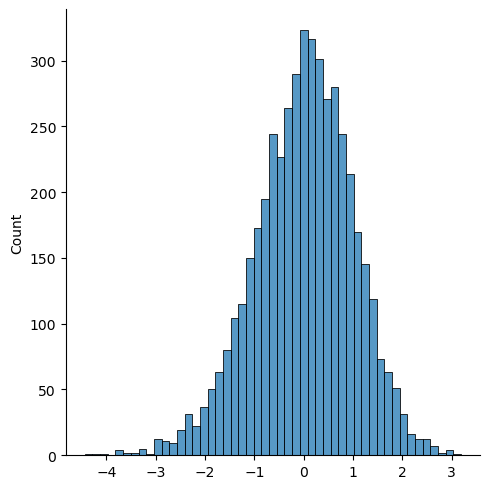

In [18]:
sns.displot(Zres)

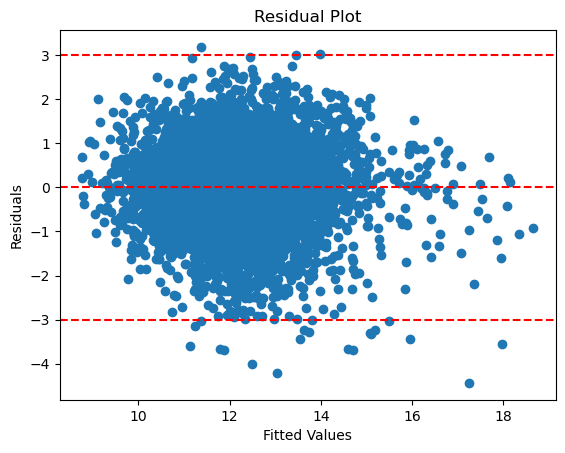

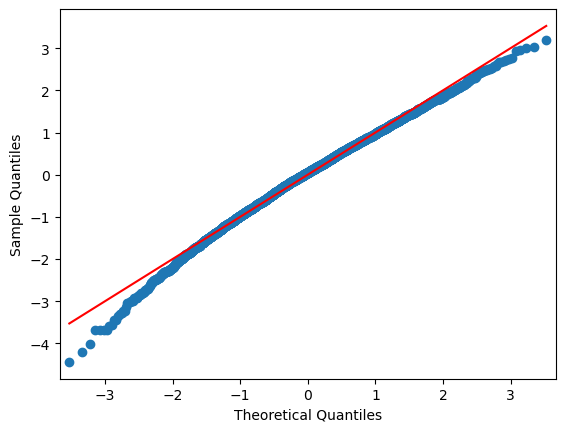

In [19]:
# Plot residuals
plt.scatter(yhat, Zres)
plt.axhline(y=Zres.mean(), c='red', linestyle='dashed')
plt.axhline(y=-3, c='red', linestyle='dashed')
plt.axhline(y=+3, c='red', linestyle='dashed')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# QQ plot for residuals
sm.qqplot(Zres, line='s')
plt.show()


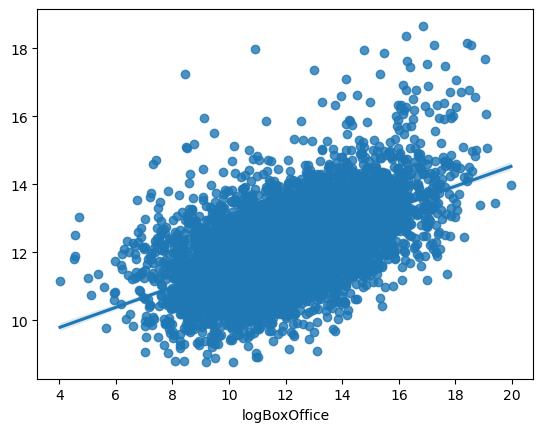

In [20]:
sns.regplot(x=y, y=yhat);

In [21]:
#Influente measures are defined only for OLS
infl = model.get_influence().summary_frame()

In [22]:
# residuals beyond 3 standard deviations
(infl.standard_resid.abs() > 3).mean()

0.004823825503355705

In [23]:
#Cook's D
infl.cooks_d.max()

0.0329020608522126

In [24]:
(infl.cooks_d > np.sqrt(4/len(data))).sum()

1

In [25]:
#Leverage
infl.hat_diag.max()

0.0239336006239583

In [26]:
#DFFits
infl.dffits.min(), infl.dffits.max()

(-0.7039356900103049, 0.239662214320248)

In [27]:
#DFBetas
for c in infl.loc[:,infl.columns.str.startswith('dfb_')]:
    print(f'{c}, {infl[c].min():.2f}, {infl[c].max():.2f}')
    

dfb_const, -0.14, 0.13
dfb_Year, -0.13, 0.17
dfb_logRunTime, -0.68, 0.07
dfb_averageRating, -0.15, 0.17
dfb_isRated, -0.09, 0.08
dfb_ForeignLanguage, -0.11, 0.08
dfb_isCoproduction, -0.10, 0.10
dfb_nominated_award, -0.12, 0.19
dfb_win_award, -0.11, 0.12
dfb_won_Oscar, -0.29, 0.22
dfb_plot_sentiment_score, -0.16, 0.14
dfb_isPositivePlot, -0.08, 0.09
dfb_isFiction, -0.16, 0.17
dfb_Cooperativeness, -0.15, 0.12
dfb_Competitiveness, -0.10, 0.12


In [28]:
data.loc[infl[infl.standard_resid.abs()>4].index,:]

,Title,Year,Country,BoxOffice,runtimeMinutes,genres,averageRating,numVotes,isRated,ForeignLanguage,...,won_Oscar,plot_sentiment_polarity,plot_sentiment_score,isPositivePlot,isFiction,Competitiveness,Cooperativeness,logBoxOffice,logRunTime,logNumVotes
398,Confession of a Child of the Century,2012,"[France, Germany, United Kingdom]",94.325069,120.0,"Drama,Romance",4.3,646,True,True,...,False,positive,0.997837,1.0,True,11.977705,11.617964,4.546747,4.787492,6.470800
1419,Dog Eat Dog,2008,[Colombia],108.741634,106.0,Thriller,6.6,1818,True,False,...,False,positive,0.990078,1.0,True,9.573698,10.539953,4.688975,4.663439,7.505492
1638,La Flor,2018,[Argentina],4699.132083,808.0,"Drama,Fantasy,Musical",7.4,784,False,False,...,False,positive,0.998418,1.0,True,9.193276,10.530679,8.455133,6.694562,6.664409


In [29]:
data.BoxOffice.describe()

count    4.768000e+03
mean     2.621985e+06
std      1.280807e+07
min      5.609115e+01
25%      3.879208e+04
50%      1.991977e+05
75%      1.066160e+06
max      4.667280e+08
Name: BoxOffice, dtype: float64

In [30]:
from numpy import corrcoef

In [31]:
corrcoef(data.Competitiveness, data.Cooperativeness)

array([[1.        , 0.73223444],
       [0.73223444, 1.        ]])

In [42]:
X.drop(columns=['const']).corr().to_excel('../30-output/correlations.xlsx')

<Axes: >

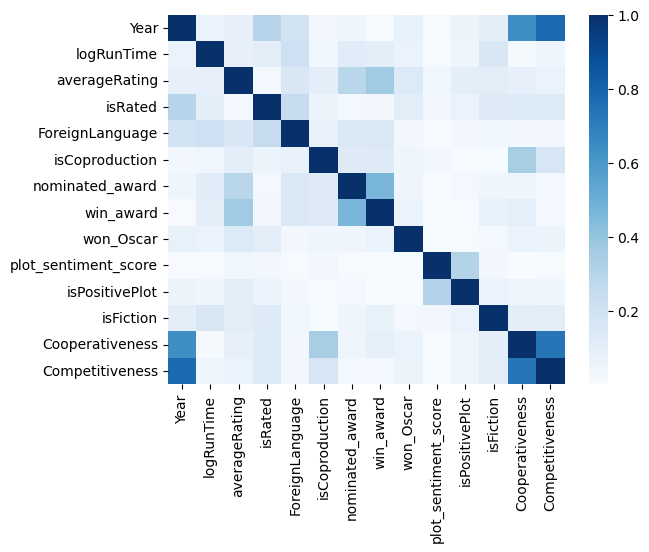

In [41]:
sns.heatmap(X.drop(columns=['const']).corr().abs(), cmap='Blues')

In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [34]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif.sort_values('VIF', ascending=False)

,VIF,variable
0,113590.718008,const
14,5.396933,Competitiveness
13,4.288563,Cooperativeness
1,3.105746,Year
6,2.081974,isCoproduction
8,1.408279,win_award
7,1.321590,nominated_award
3,1.289660,averageRating
5,1.213738,ForeignLanguage
4,1.209692,isRated


# Make some tables

In [35]:
eda = X.drop(columns=['const']).describe()
eda

,Year,logRunTime,averageRating,isRated,ForeignLanguage,isCoproduction,nominated_award,win_award,won_Oscar,plot_sentiment_score,isPositivePlot,isFiction,Cooperativeness,Competitiveness
count,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000
mean,2007.532089,4.675169,6.589828,0.472735,0.215604,0.390310,0.842282,0.741611,0.013842,0.943915,0.753146,0.960570,9.947612,9.943312
std,10.269896,0.195871,0.919349,0.499308,0.411284,0.487871,0.364515,0.437795,0.116848,0.106181,0.431226,0.194635,1.917194,1.838847
min,1980.000000,3.871201,1.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500179,0.000000,0.000000,2.476538,1.098612
25%,2001.000000,4.543295,6.100000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.954118,1.000000,1.000000,8.599455,8.552734
50%,2010.000000,4.653960,6.700000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.992169,1.000000,1.000000,10.001884,10.158909
75%,2016.000000,4.779123,7.200000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.997623,1.000000,1.000000,11.471678,11.492900
max,2022.000000,6.694562,8.900000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999429,1.000000,1.000000,13.499464,13.093114


In [36]:
eda.to_excel('../30-output/EDA.xlsx')